In [24]:
using DataFrames, CSV, Statistics, Optim, Plots #UnPack
using Distributions, StatsBase, LaTeXStrings
using SkyCoords
using PairPlots, CairoMakie

In [2]:
#df = DataFrame(CSV.File("./data/pleiades_10.csv"))
df = DataFrame(CSV.File("./data/pleiades_field.csv"))

# alpha, delta, rango = 19.997, -45.548, 10
# conditions = (alpha-rango .< df.pmra .< alpha+rango) .& (delta-rango .< df.pmdec .< delta+rango) .& 
#             (4 .< df.parallax .< 10)
# df = df[conditions, :]

df.parallax = df.parallax * 1000
df.parallax_error = df.parallax_error * 1000
#filter(:x => x -> !any(f -> f(x), (ismissing, isnothing, isnan)), df)
#first(df, 5)
nrow(df)

1965

In [3]:
function log_likelihood(X::Vector, params::Vector)
    nc, s1, s2, mu1, mu2 = params[1], params[2], params[3], params[4], params[5]
    Ac = -0.5 * ((X .- mu1)./s1).^2
    Be = -0.5 * ((X .- mu2)./s2).^2
    y = nc./(sqrt(2 * pi) .* s1) .* exp.(Ac) + (1-nc)./(sqrt(2 * pi) .* s2) .* exp.(Be)
    return sum(log.(y))
end

function log_prior(params::Vector)
    nc, sc, sf, mu_c, mu_f = params[1], params[2], params[3], params[4], params[5]
    if 0.0 < nc < 1.0 && 0.0 < sc < 10.0 && 0.0 < sf < 10.0
        return 0.0
    end
    return -Inf
end

function log_probability(params::Vector, x::Vector)
    lp = log_prior(params)
    if !isfinite(lp)
        return -Inf
    end
    return lp + log_likelihood(x, params)
end

log_probability (generic function with 1 method)

In [4]:
make_closures(X) = params -> -log_likelihood(X, params)

make_closures (generic function with 1 method)

In [5]:
nc, s1, s2 = 0.5, std(df.pmra)/2, std(df.pmra)
mu1, mu2 = mean(df.pmra), mean(df.pmra)
initparams_pmra = Vector{Float64}([nc, s1, s2, mu1, mu2])
nll = make_closures(df.pmra)
opt_pmra = optimize(nll, initparams_pmra, NelderMead(), autodiff=:forward)
param_pmra = Optim.minimizer(opt_pmra)
println(nll(initparams_pmra))
println(log_prior(initparams_pmra))
#println(log_probability(initparams_pmra, df.pmra))
println(log_probability(param_pmra, df.pmra))

5231.467297555881
0.0
-5016.852824613249


In [6]:
nc, s1, s2 = 0.5, std(df.pmdec)/2, std(df.pmdec)
mu1, mu2 = mean(df.pmdec), mean(df.pmdec)
initparams_pmdec = Vector{Float64}([nc, s1, s2, mu1, mu2])
nll = make_closures(df.pmdec)
opt_pmdec = optimize(nll, initparams_pmdec, NelderMead(), autodiff=:forward)
param_pmdec = Optim.minimizer(opt_pmdec)
println(nll(initparams_pmdec))
println(log_prior(initparams_pmdec))
#println(log_probability(initparams_pmdec, df.pmdec))
println(log_probability(param_pmdec, df.pmdec))

5478.40787366097
0.0
-5284.322658122615


In [134]:
function one_mcmc(n_iter::Number, data::Vector, params::Vector, a::Number)

    x = ones(( n_iter, length(params) ))
    x[1,:] = [params][1]

    space = zeros(length(params))

    for i in 2:n_iter
        
        for j in 1:length(params)
            #space[j] = x[i-1,j] + a * rand(Uniform(0, 1), 1)[1]
            space[j] = x[i-1,j] + a * rand()
        end

        present = log_probability(params, data)
        future = log_probability(space, data)

        alpha = min( exp(future - present), 1.0)
        g = rand()

        if alpha > g

            for k in 1:length(params)
                x[i,k] = space[k]
            end

        else
            x[i,:] = x[i-1,:]     
        end
    end

    return x[:,:,:]
end


function run_mcmc(n_iter::Number, n_walkers::Number, data::Vector, params::Vector, n_dim::Number, a::Number)
    
    # iterations, dimension, walkers
    mcmc_chains = ones(( n_iter, n_dim, n_walkers ))
    
    for walkers in 1:n_walkers
        
        one_chain = one_mcmc(n_iter, data, params, a)
        mcmc_chains[:,:,walkers] = one_chain #[:,:,:]
        
    end
    
    return mcmc_chains
end


function get_chain(array::Array, burn_in::Number, thin::Number)
    
    array_burn_in = array[burn_in:end,:,:]
    l = []
    
    for i in 1:size(array_burn_in)[1]
        
        if i%thin == 0
            push!(l, array_burn_in[i,:,:])
        end
    end
    
    l_thin = reshape( l, (size(array_burn_in)[1] * size(array_burn_in)[3], size(array_burn_in)[2] ) )
    
    return l_thin
end

get_chain (generic function with 2 methods)

In [162]:
test_array = mcmc[51:end,:,:];
size(test_array)

(950, 5, 200)

In [186]:
l = ones(( size(test_array)[1], size(test_array)[2], size(test_array)[3] ))
thin = 5
    
for i in 1:size(test_array)[1]
    if mod(i,thin) == 0    #i%thin == 0
        #push!(l, test_array[i,:,:])
        l[i,:,:] = test_array[i,:,:]
    end
end

In [199]:
#l[(l[:,:,:] != 1.0), :]
size(l[l .!= 1.0])

(190000,)

In [185]:
if mod(9,3) == 0
    println('yes')
end

LoadError: syntax: character literal contains multiple characters

In [141]:
test = get_chain(mcmc, 100, 1);

LoadError: DimensionMismatch: new dimensions (180200, 5) must be consistent with array size 901

In [137]:
1000*200

200000

In [139]:
10%1

0

In [136]:
size(mcmc)

(1000, 5, 200)

In [140]:
typeof(mcmc)

Array{Float64, 3}

In [107]:
# chain = one_mcmc(100, df.pmra, param_pmra, 0.01);
mcmc = run_mcmc(1000, 200, df.pmra, param_pmra, length(param_pmra), 0.01);

In [118]:
size(mcmc)[1]

1000

In [96]:
# for i in 1:size(chain)[2]
#     println(minimum(chain[:,i]),' ', maximum(chain[:,i]))
# end
#mcmc[:,:,1][:,1]

In [114]:
p = Any[]
labels = Tuple([L"n_c", L"\sigma_c", L"\sigma_f", L"\mu_c", L"\mu_f"])

for i in 1:size(mcmc)[3]
    for j in 1:size(mcmc)[2]
        push!(p, plot(1:size(mcmc)[1], mcmc[:,:,i][:,j], ylabel=labels[j]) )
    end
end

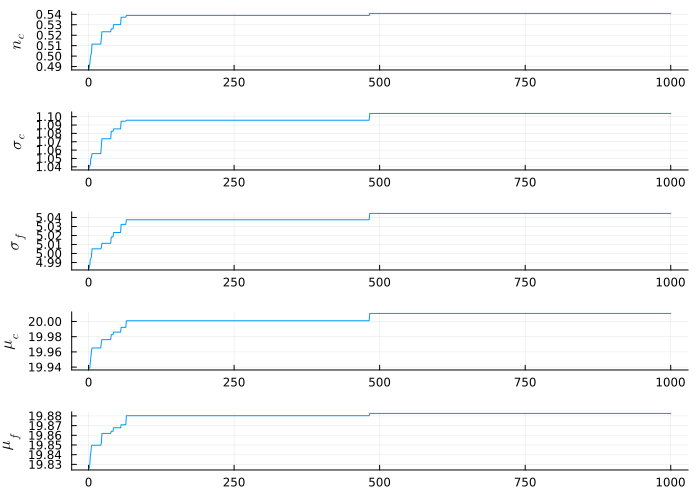

In [115]:
plot(p[1], p[2], p[3], p[4], p[5], layout=(5, 1), legend=false)
plot!(size=(700,500))

In [116]:
# p = Any[]
# labels = Tuple([L"n_c", L"\sigma_c", L"\sigma_f", L"\mu_c", L"\mu_f"])

# for i in 1:size(chain)[2]
#   push!(p, plot(1:size(chain)[1], chain[:,i], ylabel=labels[i], color=:black, lw=1.5, tickfontsize=5))
# end

# plot(p[1], p[2], p[3], p[4], p[5], layout=(5, 1), legend=false)
# plot!(size=(700,500))

In [53]:
#labels = Dict(L"n_c", L"\sigma_c", L"\sigma_f", L"\mu_c", L"\mu_f")
#labels = Dict(:1 => "parameter 1",:2 => "parameter 1",:3 => "parameter 1",:4 => "parameter 1",:5 => "parameter 1")

In [117]:
#quantile(test[:,5], 0.5) [labels[i] for i in 1:1]
pairplot(mcmc)

LoadError: PairPlots expects a matrix or Tables.jl compatible table for each series.